In [1]:
# Importa a gdal
from osgeo import gdal
gdal.UseExceptions()
from gdalconst import *
# Importa o matplotlib
import matplotlib.pyplot as plt
# Importa o Numpy
import numpy as np

# Abre a imagem NIR do CBERS para calcular a máscara de nuvens:

In [3]:
nome_arquivo_NIR = "../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.tif"
print ("Abrindo o arquivo: " + nome_arquivo_NIR)

# Tenta abrir a imagem
try:
    raster_NIR = gdal.Open(nome_arquivo_NIR, GA_ReadOnly)
    print("Arquivo aberto com sucesso!")
except:
    print("Erro na abertura do arquivo!")

Abrindo o arquivo: ../imagens/CBERS_4_MUX_20180131_172_139_L2/20180131_BAND8/20180131_BAND8.tif
Arquivo aberto com sucesso!


In [4]:
# Obtém a banda única do dataset
banda_NIR = raster_NIR.GetRasterBand(1)
# Transforma a banda em array
array_banda_NIR = banda_NIR.ReadAsArray()

# Valores acima do limiar são nuvens e ficam valendo 1. Valores abaixo do limiar valem 0.

In [5]:
# Cria a máscara de nuvens
limiar = 100
mascara_nuvens = np.copy(array_banda_NIR)
mascara_nuvens[mascara_nuvens < limiar] = False
mascara_nuvens[mascara_nuvens >= limiar] = True

In [6]:
print("Estatísticas:")
print("")

print("Valores banda NIR:")
print("Min: ", array_banda_NIR.min())
print("Max: ", array_banda_NIR.max())
print("")

print("Valores máscara de Núvens:")
print("Min: ", mascara_nuvens.min())
print("Max: ", mascara_nuvens.max())
print("")

Estatísticas:

Valores banda NIR:
Min:  0
Max:  255

Valores máscara de Núvens:
Min:  0
Max:  1



# Mostra a imagem NIR e a Máscara de Nuvens ao lado

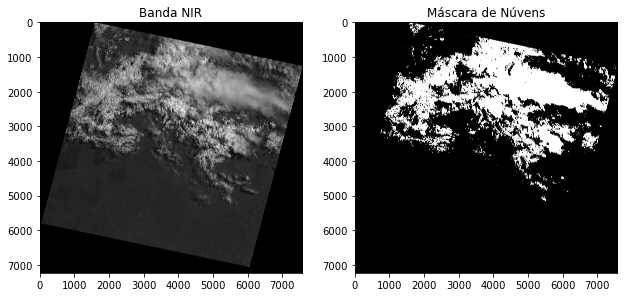

In [7]:
# Cria a figura
plt.figure(figsize = (16, 8))

# Mostra a imagem NIR
plt.subplot(131)
plt.title("Banda NIR")
plt.imshow(array_banda_NIR, cmap='gray');

# Mostra a máscara de nuvens
plt.subplot(132)
plt.title("Máscara de Núvens")
plt.imshow(mascara_nuvens, cmap='gray');

# Salva a máscara

In [8]:
# Obter a data da imagem
data_imagem = '20180131'

#Salva a máscara como png
import matplotlib
matplotlib.image.imsave('../imagens/mascara_nuvens_CBERS_'+data_imagem+'.png', mascara_nuvens)